# Прогнозирование температуры звезды

Изучение данных обсерватории «Небо на ладони». Разработка модели нейронной сети, которая умеет определять температуру на поверхности обнаруженных звёзд. 

**Данные:**

В исследовании используются данные с характеристиками уже изученных 240 звёзд из базы обсерватории.  Данные для работы находятся в файле с Признаками:
- `L/Lo` — относительная светимость (светимость звезды относительно Солнца),
- `R/Ro` — относительный радиус (радиус звезды относительно радиуса Солнца),
- `Mv` — абсолютная звёздная величина Mv, физическая величина, характеризующая блеск звезды,
- Звёздный цвет (`white, red, blue, yellow, yellow-orange` и др.) — цвет звезды, который определяют на основе спектрального анализа.
- Тип звезды: от `коричневого карлика` до `Гипергиганта`.
- `T(K)` - абсолютная температура в кельвинах (температура на поверхности звезды в Кельвинах).

**Цели исследования:**
* Проанализировать данные обсерватории «Небо на ладони»,
* Изучить взаимосвязь между имеющимися признаками в данных и подготовить данные для прогнозных нейронных сетей (baseline и с гиперпараметрами),
* Разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды,
* Дать рекомендации обсерватории: выводы и дополнительные предложения при сравнении двух моделей.

**Задачи исследования:**
* Разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

##  Исследование файлов и изучение общей информации

### Импорт библиотек:

In [1]:
!pip install phik -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

import phik
import os
import warnings
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import tensorflow as tf
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
warnings.filterwarnings('ignore')

In [4]:
# зададим константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

### Запись данных из csv-файлов и сохранение в датафреймы.

Путь к файлу (на сервере https://code.s3.yandex.net): `/datasets/6_class.csv `  

In [5]:
# функция для записи файлов с попыткой загрузки с локального сервера,затем с файл-сервера 
def write_read_csv(local, remote, sep): 
    try:
        if os.path.exists(local):
            return pd.read_csv(local, sep=sep)
        elif os.path.exists(remote):
            return pd.read_csv(remote, sep=sep)
    except FileNotFoundError:
        print('Файл не найден')

In [6]:
# запишем данные из csv-файла в датафреймы
dt_stars = write_read_csv(
    'datasets/6_class.csv', '/datasets/6_class.csv', sep=',')

In [7]:
dt_stars.info()
dt_stars.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
235,235,38940,374830.0,1356.0,-9.93,5,Blue
236,236,30839,834042.0,1194.0,-10.63,5,Blue
237,237,8829,537493.0,1423.0,-10.73,5,White
238,238,9235,404940.0,1112.0,-11.23,5,White
239,239,37882,294903.0,1783.0,-7.80,5,Blue


По общей информации и по строкам видно, что датафрейм `dt_stars` содержит данные с характеристиками уже изученных 240 звёзд, в том числе целевой признак -  абсолютная температура в Кельвинах (температура на поверхности звезды в Кельвинах).
Данные в таблицах соответствуют описанию: каждая колонка соответсвует своему типу данных. Предвариетельно замечено, что пропуски в данных отсутстсуют. Однако, есть вопросы к стилю названия колонок. 

Также замечен нефункциональный признак `Unnamed: 0`, который дублирует позицию звезды в списке, удалим данный столбец на этапе предобработки данных (неинформативен).

Приведем названия признаков к стилю snake_case:

In [8]:
def clean_column_name(col):
    # удаляем скобки с содержимым,пробел меняем на подчеркивания, приводим к ниж.регистру
    col = re.sub(r'\([^)]*\)', '', col).replace(' ', '_').lower().strip('_')
    return col

In [9]:
dt_stars = dt_stars.rename(columns = lambda x: clean_column_name(x))
print(dt_stars.columns.tolist())

['unnamed:_0', 'temperature', 'luminosity', 'radius', 'absolute_magnitude', 'star_type', 'star_color']


**Вывод по разделу 'Загрузка исходных и исследование файлов'**

На данном этапе были произведены: 
- Импорт необходимых библиотек,
- Запись данных из csv-файлов и сохранение в датафрейм,
- Изучение общей информации из записанного файла,
- Приведение названия признаков к стилю snake_case.

## Предобработка и анализ данных

### Предобработка данных

Удалим неинформативый столбец `unnamed:_0`: 

In [10]:
dt_stars = dt_stars.drop(columns=['unnamed:_0'])

**Проверка наличия пропущенных значений и дубликатов в датафреймах.** 

Ранее мы установили. что пропуски отстсвуют в датасете. Перед обработкой дубликатов создадим копию датафрейма и зафиксируем их размер до преобразования:

In [11]:
temp_dt_stars = dt_stars.copy() 
print(f'Длина датасета dt_stars: {len(temp_dt_stars)}')

Длина датасета dt_stars: 240


Исследуем датафрейм `dt_stars` на явные дубликаты строк:

In [12]:
dt_stars.duplicated().sum()

0

Явные дубликаты отсутствуют. Также проверим данные категориальные данные на разночтения: 

In [13]:
# функция для перебора столбцов с выводом уникальных значений на экран 
def get_unique_cats(cat_cols):
    for column in cat_cols:
        unique_vals = cat_cols[column].unique()
        print(f"Уникальные значения в колонке '{column}': {unique_vals}")

In [14]:
cat_cols_dt_stars = dt_stars[['star_color']] # кат.данные в dt_stars

# выводим на экран уникальные категории кат.колонки 
get_unique_cats(cat_cols_dt_stars)

Уникальные значения в колонке 'star_color': ['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'Blue ' 'yellowish' 'Yellowish'
 'Orange-Red' 'Blue white ' 'Blue-White']


Обнаружили проблему: в колонке `star_color` много вариантов написания одного и того же цвета из-за различий в регистре, использовании дефисов и лишних пробелов, а именно:
- `Blue White`, `Blue white, 'Blue-white', 'Blue-White', 'Blue white '`
- `'yellow-white', 'White-Yellow'` (справка: термины «yellow-white» (желто-белый) и «white-yellow» (бело-желтый) практически не различаются и описывают один и тот же цветовой диапазон, характерный для звезд спектрального класса F (температура 6000–7400 K). Это переходный оттенок между белыми звездами класса A и желтыми класса G, где преобладает белый цвет с легким желтоватым оттенком). 
- `'Yellowish', 'yellowish'`
- `'white', 'Whitish'`  - это разные цвета: «Yellow white» и «yellowish white» описывают оттенки белого с желтизной, но различаются интенсивностью, поэтому они должны остаться оба. 
- `'Blue ' `(с пробелом в конце)
Чтобы привести всё к единому виду, нужно все строки привести к нижнему регистру, удалить пробелы по краям, заменить на дефисы пробелы. Тогда похожие значения объединятся. 

In [15]:
# изменяем нижний регистр, удаляем пробелы, меняем  пробелы на дефисы
dt_stars['star_color'] = (
    dt_stars['star_color'].str.lower().str.strip().str.replace(' ', '-', regex=False)
)
dt_stars['star_color'].unique()

array(['red', 'blue-white', 'white', 'yellowish-white',
       'pale-yellow-orange', 'blue', 'whitish', 'yellow-white', 'orange',
       'white-yellow', 'yellowish', 'orange-red'], dtype=object)

Сопоставим размеры датасета и копии до преобразований, чтобы убедиться в верной предобработке данных:

In [16]:
display(f'Удалено строк после обработки: {len(temp_dt_stars)-len(dt_stars)} строк(и)') 

'Удалено строк после обработки: 0 строк(и)'

**Вывод по этапу 'Предобработки данных'**

На этапе предобработки данных:
- Мы проверили данные на пропуски, явные и неявные дубликаты категориальных столбцов в датасете: было отмечено отсутствие дубликтов и пропусков.
- Заменены разночтения в категориальной колонке `star_color`: из имевшихся 19 категорий осталось 12.
- Были сопоставлены размеры датасетов до и после предобратки: удалено 0 строк. 

### Исследовательский анализ
На данном этапе проведем статистический анализ всех признаков датасета и построим для них графики. Проверим данные на выбросы, необычное распределение количественных признаков. 

**Анализ статистик**

In [17]:
#  функция для вывода статистик для каждого параметра
def stats_describe(name, df, columns):
    stats = df[columns].describe().T
    stats = stats.style.set_caption(f"<b>{name}</b>") 
    return stats

Отобразим статистики для каждого параметра в датасете:

In [18]:
# отбор количественных признаков в dt_train
num_cols_dt_stars = dt_stars.select_dtypes(include=['int64', 'float64']).columns

stats_describe('Статистики характеристик звезд', dt_stars, num_cols_dt_stars)

,count,mean,std,min,25%,50%,75%,max
temperature,240.000000,10497.462500,9552.425037,1939.000000,3344.250000,5776.000000,15055.500000,40000.000000
luminosity,240.000000,107188.361635,179432.244940,0.000080,0.000865,0.070500,198050.000000,849420.000000
radius,240.000000,237.157781,517.155763,0.008400,0.102750,0.762500,42.750000,1948.500000
absolute_magnitude,240.000000,4.382396,10.532512,-11.920000,-6.232500,8.313000,13.697500,20.060000
star_type,240.000000,2.500000,1.711394,0.000000,1.000000,2.500000,4.000000,5.000000


**Анализ статистик количественных признаков в датасете**

* `Температура`: от 1939 до 40000 K, среднее = 10500, медиана = 5776 K, распределение смещено вправо, значит, есть много горячих звёзд.
* `Светимость`: сильный разброс от 0.00008 до 849420, среднее = 107 тыс., медиана всего 0.07, подавляющее большинство звёзд тусклые, но присутствуют экстремально яркие.
* `Радиус`: сильный разброс от 0.008 до 1948.5 солнечных радиусов, среднее  = 237, медиана 0.76, сильная асимметрия, значит, есть звёзды-гиганты.
* `Блеск звезды`, абсолютная звёздная величина от -11.92 до 20.06, среднее  = 4.38, медиана = 8.31, диапазон охватывает как очень яркие, так и крайне тусклые звезды.
* `Тип звезды` со значениями от 0 до 5, среднее и медиана 2.5. 

Данные сильно скошены, присутствуют выраженные выбросы, что возможно объясняется характерностью звёздных каталогов, то есть сочетания карликов и гигантов. Это нужно учитывать при дальнейшем моделировании. 

**Графики количественных и категориальных признаков**

Количественные признаки и их графики. Построим гистрограммы распределения всех количественных признаков по  `dt_stars`:

In [19]:
# разделим признаки по типам: неприрывные признаки и дискретные 
continuous_cols = ['temperature', 'luminosity', 'radius', 'absolute_magnitude']
discrete_cols = ['star_type']

# создадим словарь с подписями (название, ось X, ось Y)  для диаграм 
labels = {
    'temperature': ['Температура', 'Температура  в K', 'Количество звезд'],
    'luminosity': ['Светимость отн.:', 'Светимость относительно св-ти Солнца', 'Количество звезд'],
    'radius': ['Радиус отн.', 'Радиус звезды отн-но радиуса Солнца', 'Количество звезд'],
    'absolute_magnitude': ['Блеск звезды', 'Блеск звезды в звездных величинах ', 'Количество звезд'],
    'star_type': ['Тип звезды', 'Тип от 0 до 5', 'Количество звезд']
}

In [20]:
# функция для построения графиков распределения по показателям
def plot_enhanced(df, cols, labels_dict, plot_type='auto', figsize=(16, 12)):
    n_cols = min(2, len(cols))  # не более 2 колонок
    n_rows = (len(cols) + n_cols - 1) // n_cols
    if len(cols) == 1: figsize = (figsize[0], 5)  # фиксированная высота для одного графика
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = np.array(axes).flatten()  # для единообразия обработки
    for i, col in enumerate(cols):
        ax = axes[i]
        if plot_type == 'auto': # автовыбор типа графика
            current_plot_type = 'count' if df[col].nunique() <= 15 else 'hist'
        else: current_plot_type = plot_type
        
        # построение графиков
        if current_plot_type == 'count':
            sns.countplot(x=col, data=df, ax=ax, color='#DDA00D', alpha=0.85)
            for p in ax.patches:
                ax.annotate(f'{p.get_height():.0f}', 
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', xytext=(0, 5), 
                           textcoords='offset points',fontsize=9)
        else: sns.histplot(df[col], ax=ax, color='#DDA00D', alpha=0.85, kde=True, bins=15)
        
        # установка подписей
        title, xlabel, ylabel = labels_dict.get(col, ['', '', ''])
        ax.set_title(title, fontsize=12)
        ax.set_xlabel(xlabel, fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.tick_params(labelsize=9)
    
    fig.suptitle('Анализ распределения показателей', 
                 fontsize=16, fontweight='bold', 
                 y=0.98 if len(cols) > 1 else 0.95) # единый заголовок
    plt.subplots_adjust(top=0.9 if len(cols) > 1 else 0.85)  # регулировка верхнего отступа
    plt.show()

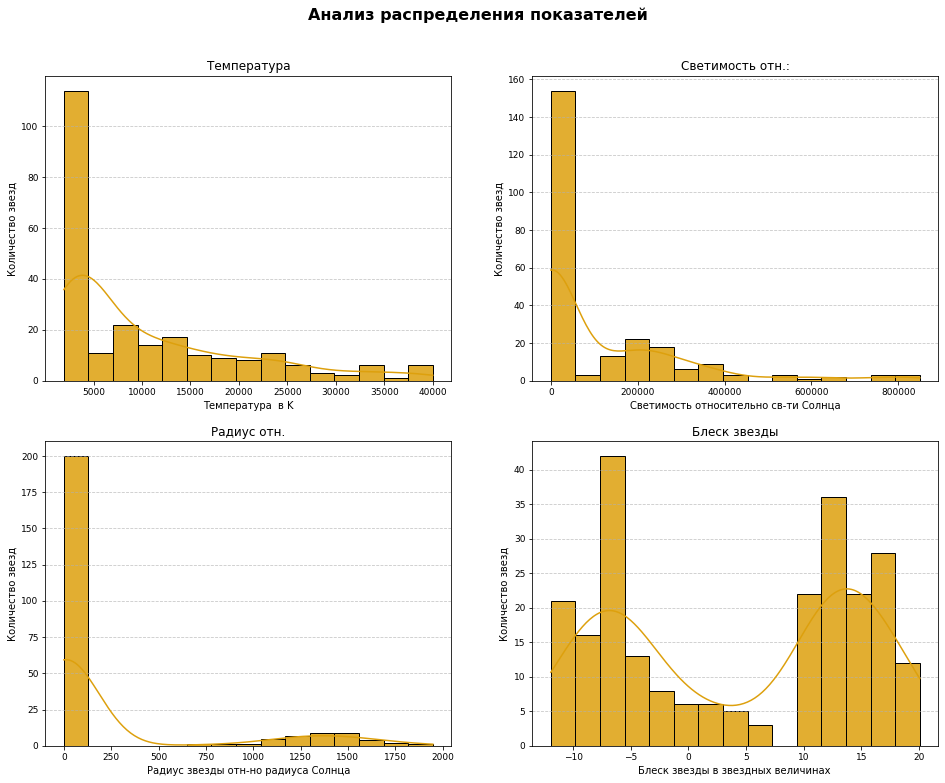

In [21]:
# строим графики для непрерывных признаков 
plot_enhanced(dt_stars, continuous_cols, labels)

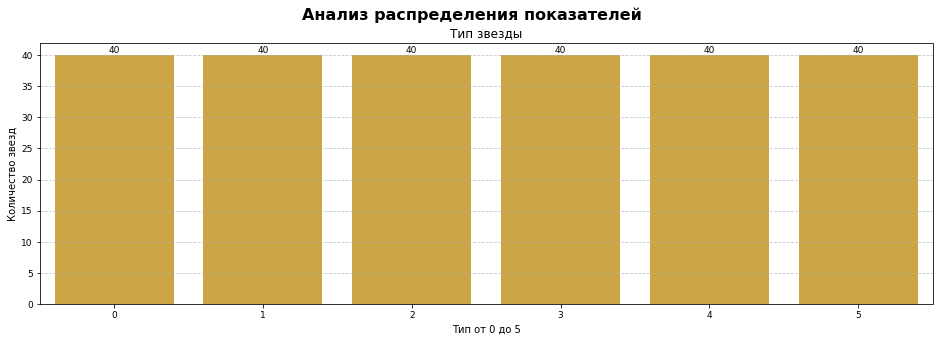

In [22]:
# строим графики для дискретных признаков 
plot_enhanced(dt_stars, discrete_cols, labels)

**Анализ распределения количественных показателей**

- Температура, светимость, радиус имеют сильную положительную асимметрию: основная масса звёзд сосредоточена в области низких значений - это холодные карлики с малой светимостью и радиусом, однако присутствует небольшое количество звёзд-гигантов с экстремально высокими показателями  - это длинные «хвосты» распределений.
- Абсолютная звёздная величина также варьируется в широком диапазоне от очень ярких (отрицательные значения) до крайне тусклых, что отражает смешанный состав выборки.
- Тип звезды (дискретный признак) распределён практич

**Категориальные признаки и их графики**

Рассмотрим и визуализируем категориальные признаки для датафрейма:

In [23]:
# функция: столбчатые диаграммы для категориальных признаков
def bar_plot(df, cols, translation_dict):
    for col_name in cols:
        # получаем данные для построения
        value_counts = df[col_name].value_counts()
        # русское название для отображения
        display_name = translation_dict.get(col_name, col_name)
        # создаем график
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')
        for i, v in enumerate(value_counts.values): # добавляем значения на столбцы
            ax.text(i, v + 0.01 * max(value_counts.values), str(v), 
                    ha='center', va='bottom', fontweight='bold')
        
        plt.title(f'Распределение показателя "{display_name}"', fontsize=16, 
                  fontweight='bold', pad=20)
        plt.xlabel(display_name, fontsize=12)
        plt.ylabel('Количество звезд', fontsize=12)
        plt.xticks(rotation=45)
        plt.show()

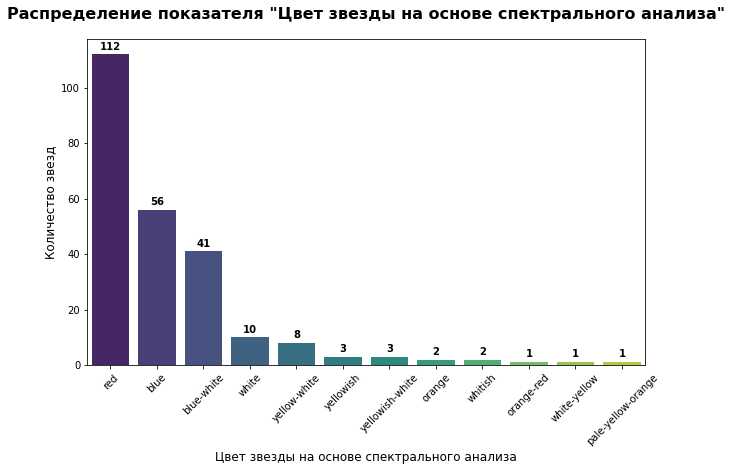

In [24]:
# словарь для обозначений английских названий на русском
column_translit = {
    'star_color': 'Цвет звезды на основе спектрального анализа'}

# строим диаграмму 
bar_plot(dt_stars, ['star_color'], column_translit)

**Анализ категориальных данных**

На графике виден сильный дисбаланс категорий. Есть одна доминирующая категория, которая насчитывает 112 Красных объектов, вторая – 56 Голубых, третья – 41 Бело-голубых, четвертая - 10 белых, пятая - 8 желто-белых. Остальные цвета встречаются значительно реже (до 3 объектов), что нормально и  типично для астрономических данных. 

Для обучения нейросети такие малочисленные категории с частотой 1–3 объекта могут привести к переобучению, если использовать их как отдельные классы при one-hot-кодировании.

Тогда объединим редкие цвета с частотой <= 3 в общую группу: `'yellowish-white', 'pale-yellow-orange', 'whitish', 'orange', 'white-yellow', 'yellowish', 'orange-red'`:
* Оранжевые и оранжево-красные (спектральные классы K–M): `'orange-red', 'orange', 'pale-yellow-orange'`,
* Желтовато-белые и жёлтые (спектральные классы F–G): `'yellowish-white', 'white-yellow', 'yellowish'`
* Беловатые (спектральный класс A): `'whitish'`  можно объединить с группой «белые», т.к. такая категория уже есть. 

### Корреляционный анализ признаков

Проведем корреляционный анализ признаков в количественной шкале для моделирования. Выявим и устраним при необходимости возможные инциденты по мультиколлинеарности.

Рассчитаем `матрицу корреляций phik` для признаков  выборки `dt_stars`:

In [25]:
def plot_phik_matrices (dt, interval_cols, name):
    corr_matrix = dt.phik_matrix(interval_cols=interval_cols)
    # визуализация матрицы корреляций
    plt.figure(figsize=(28, 25))
    sns.heatmap(corr_matrix, annot=True, 
            fmt=".2f", cmap="coolwarm",
            vmin=-1, vmax=1,
            annot_kws={"size": 17},
            linewidths=0.5)
    plt.title(name, fontsize=25, pad=20, fontweight='bold')
    plt.xticks(rotation=30, ha='right', fontsize=15)
    plt.yticks(rotation=0, fontsize=15)
    plt.show()

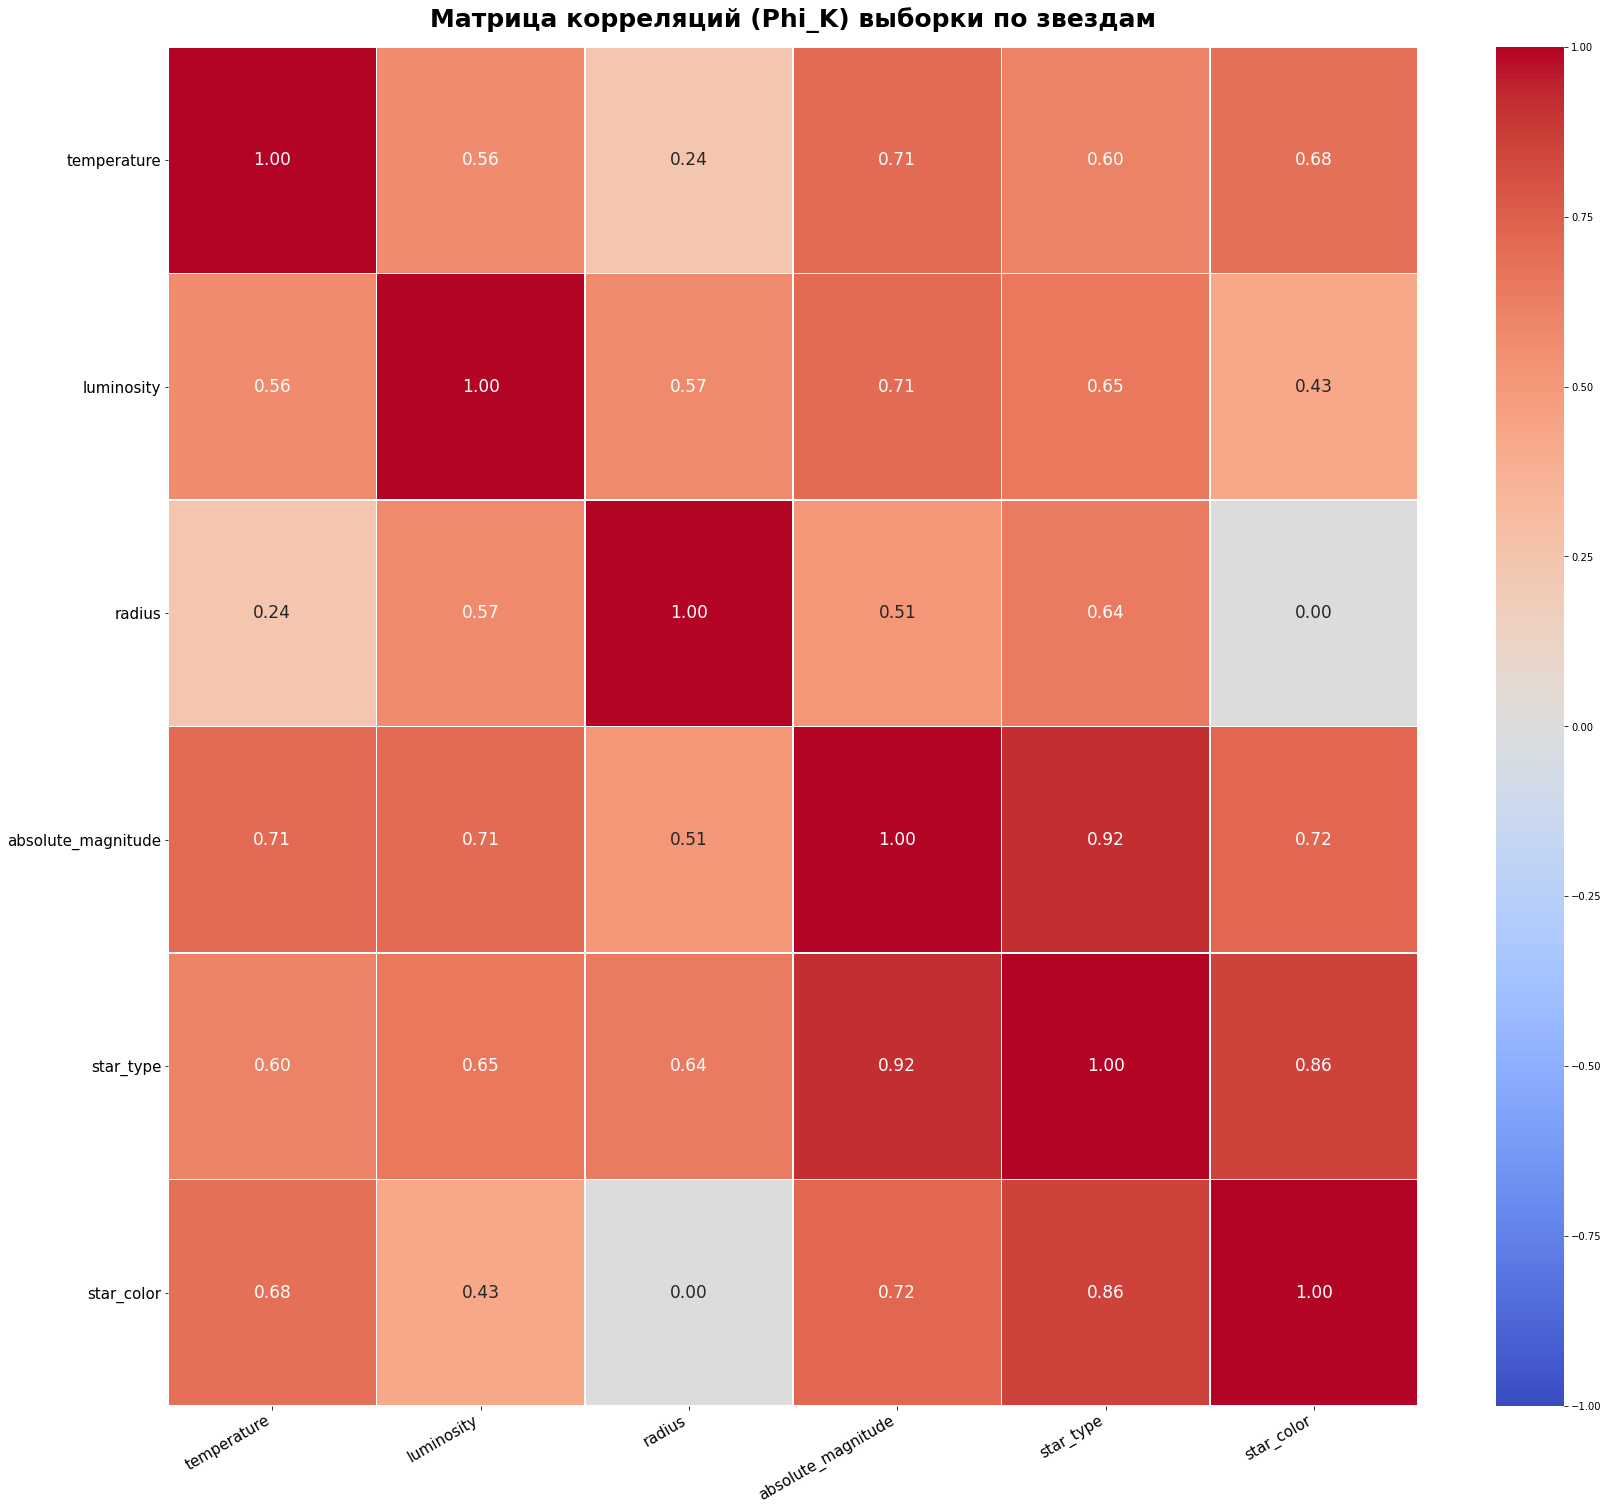

In [26]:
# определение непрерывных признаков у нас уже лежит в переменной continuous_cols  выборки
plot_phik_matrices(dt_stars, 
                   continuous_cols, 'Матрица корреляций (Phi_K) выборки по звездам')

**Анализ корреляционной матрицы** (целевой признак: температура на поверхности)

* наибольшая корреляция с температурой — цвет звезды = 0.92, что логично, так как цвет определяется температурой поверхности. Этот признак будет наиболее информативен для предсказания.
* достаточно сильная положительная связь с абсолютной звёздной величиной  = 0.71 и умеренная связь с типом звезды = 0.64,т.к., более горячие звёзды ярче и относятся к определённым типам, например, голубые гиганты.
* Слабая связь с радиусом = 0.51 и светимостью = 0.56, т.к. звёзды могут быть горячими карликами или гигантами с разным радиусом и светимостью.
* Корреляция между радиусом и светимостью = 0.86 может быть полезна для модели и не критична для нейросети.

**Общий вывод по данным для подготовки к обучению нейросети:**

* Данные не содержат пропусков и дубликатов, но требуют предобработки: нормализация и стандартизация числовых признаков из-за сильного различия в масштабах, приведение к более симметричному виду сильно скошенных признаков  таких как светимость и радиус, унификация категориального признака star_color с последующим кодированием.
* Целевая переменная (star_type) сбалансирована, что благоприятно для обучения без применения техник балансировки классов.
* Объём выборки в 240 объектов невелик, поэтому нейросеть должна быть простой, это небольшое число слоёв и нейронов с обязательным использованием регуляризации dropout для предотвращения переобучения. Возможно также стоит сравнить результаты с классическими алгоритмами случайный лес и градиентный бустинг.
* Объединить категориальные признаки `Цвет звезды` в более большие бины, чтобы не вызвать переобучения сети.

После корректной предобработки данные готовы для определения температуры на поверхности обнаруженных звёзд.

## Подготовка данных к построению модели

### Корректировки по результатам исследовательского анализа:
- группируем редкие цвета по спектральным классам
- логарифмируем `luminosity` и `radius` для уменьшения асимметрии

In [27]:
# словарь объединения
color_mapping = {
    # оранжевые и оранжево-красные объединим в  'orange-red'
    'orange-red': 'orange-red',
    'orange': 'orange-red',
    'pale-yellow-orange': 'orange-red',   
    # желтовато-белые и жёлтые объединим в 'yellowish white'
    'yellowish-white': 'yellowish-white',
    'white-yellow': 'yellowish-white',
    'yellowish': 'yellowish-white',
    # беловатые перенесем в  'white'
    'whitish': 'white'}

dt_stars['star_color'] = dt_stars['star_color'].replace(color_mapping)

In [28]:
# проверим результат группировки
dt_stars['star_color'].value_counts()

red                112
blue                56
blue-white          41
white               12
yellow-white         8
yellowish-white      7
orange-red           4
Name: star_color, dtype: int64

Логарифмируем `luminosity` и `radius` для уменьшения асимметрии:

In [29]:
dt_stars['log_luminosity'] = np.log1p(dt_stars['luminosity'])# log(1+x) для избежания нулей
dt_stars['log_radius'] = np.log1p(dt_stars['radius'])

In [30]:
# оставим только нужные признаки а исходные luminosity и radius  удалим
dt_stars.drop(['luminosity', 'radius'], axis=1, inplace=True)

###  Категоризация исходных данных и подготовка обучающей и тестовой выборки.

Целевое кодирование для признака `Цвет звезды` с использованием среднего значения температуры. Разделим данные сначала на train и test, чтобы избежать утечки:

In [31]:
X = dt_stars.drop('temperature', axis=1)
y = dt_stars['temperature']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

In [32]:
# вычислим ср. температуру для каждого цвета на обучающей выборке
color_means = y_train.groupby(X_train['star_color']).mean()
global_mean = y_train.mean()

In [33]:
# функция: замена цвета на соответствующее среднее 
def target_encode_color(col, means, global_mean):
    return col.map(means).fillna(global_mean)

In [34]:
X_train['star_color_enc'] = target_encode_color(X_train['star_color'], 
                                                color_means, global_mean)
X_test['star_color_enc'] = target_encode_color(X_test['star_color'], 
                                               color_means, global_mean)

In [35]:
# удаляем исходный текстовый столбец цвета
X_train.drop('star_color', axis=1, inplace=True)
X_test.drop('star_color', axis=1, inplace=True)

### Масштабирование количественных данных

Список числовых признаков для масштабирования, включая закодированный 'star_color' и 'star_type':

In [36]:
num_features = ['log_luminosity',
                'log_radius', 'absolute_magnitude', 'star_type', 'star_color_enc']

Для стабилизации обучения нейросети целевая переменная стандартизирована по обучающей выборке (fit на train, transform на test), чтобы избежать утечки. Для интерпретации результатов выполнено обратное преобразование предсказаний в Кельвины.

In [37]:
# масштабируем X (fit только на train) 
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train[num_features])
X_test_scaled  = x_scaler.transform(X_test[num_features])

# обратно в DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_features, index=X_train.index)
X_test_scaled  = pd.DataFrame(X_test_scaled, columns=num_features, index=X_test.index)

# масштабируем y (fit только на train, без утечки) 
y_scaler = StandardScaler()
y_train_scaled_arr = y_scaler.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_test_scaled_arr  = y_scaler.transform(y_test.to_numpy().reshape(-1, 1))

y_train_scaled = pd.DataFrame(y_train_scaled_arr, columns=['temperature_scaled'], index=y_train.index)
y_test_scaled  = pd.DataFrame(y_test_scaled_arr,  columns=['temperature_scaled'], index=y_test.index)

print("X_train_scaled:", X_train_scaled.shape, "X_test_scaled:", X_test_scaled.shape)
print("y_train_scaled:", y_train_scaled.shape, "y_test_scaled:", y_test_scaled.shape)

X_train_scaled: (180, 5) X_test_scaled: (60, 5)
y_train_scaled: (180, 1) y_test_scaled: (60, 1)


**Вывод по этапу 'Подготовка данных к построению модели'** 

На данном этапе: 
* выполнено целевое кодирование цвета на основе среднего значения температуры в обучающей выборке. Это преобразует категориальный признак в числовой, сохраняя информацию о связи с целевой переменной. Логорифмирование сильно скошенных данных в признаках `luminosity` и `radius`. 
* разделение выборок на тренировочную и тестовую до масштабирования и кодирования для предотвращения утечки данных.
* масштабирование количественных данных: все признаки стандартизированы с помощью StandardScaler, что важно для устойчивой работы нейросети.

После корректировок данные подготовлены. Целевая переменная y_train, y_test остаётся непрерывной.

## Построение базовой нейронной сети

Класс архитектуры сети (Linear + ReLU + Identity на выходе)

In [38]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.Tanh()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.Identity()   # регрессия: выход без активации

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.act2(x)

        x = self.fc3(x)
        x = self.act3(x)
        return x

Тензоры из масштабированных данных (5 признаков)

In [39]:
# X_train_scaled и X_test_scaled - это DataFrame с 5 колонками
X_train = torch.FloatTensor(X_train_scaled.values)     #  5
X_test  = torch.FloatTensor(X_test_scaled.values)      # 5

y_train_t = torch.FloatTensor(y_train_scaled.values).view(-1, 1)  # 1
y_test_t  = torch.FloatTensor(y_test_scaled.values).view(-1, 1)   #  1

n_in_neurons = X_train.shape[1]
n_out_neurons = 1

Функция обучения (Adam, цикл с епохами, forward, loss, backward, step):

In [40]:
def train_regression(net, X_train, y_train, X_test, y_test, lr=1e-3, num_epochs=300):
    optimizer = optim.Adam(net.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    train_mse_hist = []
    test_mae_hist = []
    test_rmse_hist = []

    for epoch in range(num_epochs):
        net.train()
        optimizer.zero_grad()

        preds = net.forward(X_train)
        loss_value = loss_fn(preds, y_train)
        loss_value.backward()
        optimizer.step()

        train_mse_hist.append(loss_value.item())

        net.eval()
        with torch.no_grad():
            test_preds = net.forward(X_test)
            mae = torch.mean(torch.abs(test_preds - y_test)).item()
            rmse = torch.sqrt(torch.mean((test_preds - y_test) ** 2)).item()

        test_mae_hist.append(mae)
        test_rmse_hist.append(rmse)

        if epoch % 50 == 0:
            print(f"epoch={epoch:3d} | train_mse={loss_value.item():.3f} | test_mae={mae:.1f}K | test_rmse={rmse:.1f}K")

    return train_mse_hist, test_mae_hist, test_rmse_hist

Сравнение нескольких конфигураций:

In [41]:
configs = [
    # (h1, h2)
    (8,  4),
    (16, 8),
    (32, 16),
    (64, 32),
    (32, 32)]

results = []
best_net = None
best_rmse = float("inf")
best_cfg = None

for (h1, h2) in configs:
    torch.manual_seed(RANDOM_STATE)

    net = Net(n_in_neurons, h1, h2, n_out_neurons)

    print(f"\nConfig: h1={h1}, h2={h2} (Tanh -> ReLU -> Linear)")

    train_mse_hist, test_mae_hist, test_rmse_hist = train_regression(
        net, X_train, y_train_t, X_test, y_test_t, lr=1e-3, num_epochs=300)

    final_mae = test_mae_hist[-1]
    final_rmse = test_rmse_hist[-1]
    results.append(((h1, h2), final_mae, final_rmse))

    if final_rmse < best_rmse:
        best_rmse = final_rmse
        best_net = net
        best_cfg = (h1, h2)

print("\nСравнение конфигов (ниже лучше):")
for cfg, mae_v, rmse_v in results:
    print(f"{cfg} -> MAE={mae_v:.1f}K, RMSE={rmse_v:.1f}K")

print("\nЛучшая конфигурация:", best_cfg, f"RMSE={best_rmse:.1f}K")


Config: h1=8, h2=4 (Tanh -> ReLU -> Linear)
epoch=  0 | train_mse=0.954 | test_mae=0.8K | test_rmse=1.0K
epoch= 50 | train_mse=0.799 | test_mae=0.7K | test_rmse=0.9K
epoch=100 | train_mse=0.648 | test_mae=0.7K | test_rmse=0.9K
epoch=150 | train_mse=0.514 | test_mae=0.6K | test_rmse=0.8K
epoch=200 | train_mse=0.421 | test_mae=0.5K | test_rmse=0.7K
epoch=250 | train_mse=0.367 | test_mae=0.5K | test_rmse=0.7K

Config: h1=16, h2=8 (Tanh -> ReLU -> Linear)
epoch=  0 | train_mse=0.977 | test_mae=0.9K | test_rmse=1.0K
epoch= 50 | train_mse=0.562 | test_mae=0.7K | test_rmse=0.8K
epoch=100 | train_mse=0.307 | test_mae=0.4K | test_rmse=0.6K
epoch=150 | train_mse=0.283 | test_mae=0.4K | test_rmse=0.6K
epoch=200 | train_mse=0.278 | test_mae=0.3K | test_rmse=0.6K
epoch=250 | train_mse=0.274 | test_mae=0.3K | test_rmse=0.6K

Config: h1=32, h2=16 (Tanh -> ReLU -> Linear)
epoch=  0 | train_mse=1.037 | test_mae=0.8K | test_rmse=1.1K
epoch= 50 | train_mse=0.319 | test_mae=0.4K | test_rmse=0.6K
epoch=10

График 'Факт–Прогноз'. А `y_true` и `y_pred` должны быть 1D массивами одинаковой длины. Сначала переведем обратно в Кельвины: 

In [42]:
best_net.eval()
with torch.no_grad():
    y_pred_scaled = best_net(X_test).cpu().numpy()   

# обратно в K
y_pred_kelvin = y_scaler.inverse_transform(y_pred_scaled).reshape(-1)
y_true_kelvin = y_test.to_numpy()  # исходный y_test в K

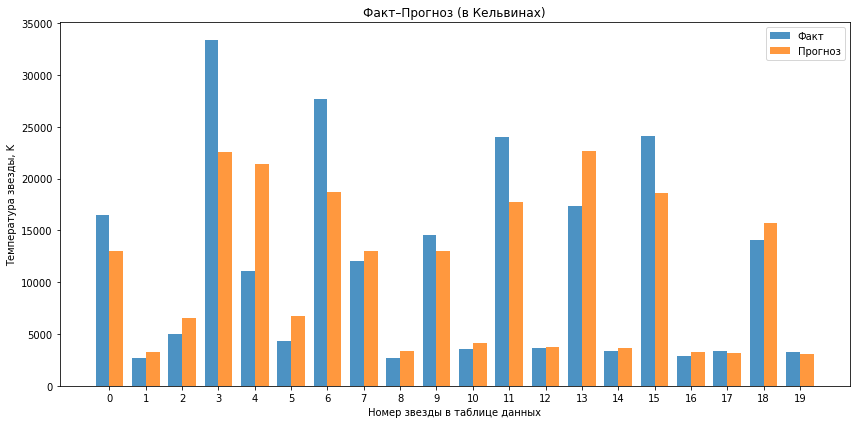

MAE=2790.5 K, RMSE=4778.0 K


In [43]:
k = min(20, len(y_true_kelvin)) # 20 первых звезд для читаемости 
y_true_k = y_true_kelvin[:k]
y_pred_k = y_pred_kelvin[:k]

idx = np.arange(k)
bar_width = 0.38
shift = bar_width / 2

plt.figure(figsize=(12, 6))
plt.bar(idx - shift, y_true_k, width=bar_width, label="Факт", alpha=0.8)
plt.bar(idx + shift, y_pred_k, width=bar_width, label="Прогноз", alpha=0.8)

plt.xlabel("Номер звезды в таблице данных")
plt.ylabel("Температура звезды, K")
plt.title("Факт–Прогноз (в Кельвинах)")
plt.xticks(idx)
plt.legend()
plt.tight_layout()
plt.show()

# метрики (в Кельвинах)
mae = np.mean(np.abs(y_true_kelvin - y_pred_kelvin))
rmse = np.sqrt(np.mean((y_true_kelvin - y_pred_kelvin) ** 2))
print(f"MAE={mae:.1f} K, RMSE={rmse:.1f} K")

**Вывод по baseline-модели**

Построенная нейросеть после стандартизации целевой переменной выдаёт прогнозы температуры в корректном диапазоне Кельвинов и в принципе улавливает порядок величин: холодные звёзды остаются холодными, горячие чаще всего предсказываются как горячие. При этом точность остаётся средней: MAE = 2790.5 K, RMSE = 4778.0 K. Ошибка возрастает на звёздах с высокими температурами - в районе 20–35 тыс. K, и на отдельных объектах наблюдается переоценка или недооценка, что видно по расхождению столбиков “Факт” и “Прогноз”. Для baseline на небольшом датасете это ожидаемо: модель даёт рабочую отправную точку, но требует дальнейшей настройки ее архитектуры и гиперпараметров.

## Улучшение нейронной сети

Сеть с той же архитектурой с добавлением Dropout:

In [44]:
class Net(nn.Module):
    # архитектура baseline: Linear, Tanh,Linear,ReLU,Linear
    def __init__(self, n_in, h1, h2, n_out, dropout=0.0):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(n_in, h1)
        self.act1 = nn.Tanh()
        self.drop1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(h1, h2)
        self.act2 = nn.ReLU()
        self.drop2 = nn.Dropout(dropout)

        self.fc3 = nn.Linear(h2, n_out)
        self.act3 = nn.Identity()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.drop1(x)

        x = self.fc2(x)
        x = self.act2(x)
        x = self.drop2(x)

        x = self.fc3(x)
        x = self.act3(x)
        return x

Подготовка тензоров и DataLoader, batch_size параметр

In [45]:
# X: уже scaled и есть DataFrame
X_train_t = torch.FloatTensor(X_train_scaled.values)
X_test_t  = torch.FloatTensor(X_test_scaled.values)

# y: scaled в масштабе StandardScaler и с  формой (N,1)
y_train_t = torch.FloatTensor(y_train_scaled.values).view(-1, 1)
y_test_t  = torch.FloatTensor(y_test_scaled.values).view(-1, 1)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

Обучение сети, RMSE в Кельвинах :

In [46]:
def rmse_kelvin(y_true_k, y_pred_k):
    return float(np.sqrt(np.mean((y_true_k - y_pred_k) ** 2)))

def train_one_config(dropout, batch_size, lr=1e-3, 
                     epochs=400, weight_decay=1e-4, h1=32, h2=16):

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)

    net = Net(n_in=X_train_t.shape[1], h1=h1, h2=h2, n_out=1, dropout=dropout)
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    # на обучающей 
    for epoch in range(epochs):
        net.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = net(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()

    # предсказание на тесте масш.
    net.eval()
    preds_scaled = []
    with torch.no_grad():
        for xb, _ in test_loader:
            preds_scaled.append(net(xb).cpu().numpy())
    y_pred_scaled = np.vstack(preds_scaled)

    # обратно в Кельвины переводим
    y_pred_kelvin = y_scaler.inverse_transform(y_pred_scaled).reshape(-1)
    y_true_kelvin = y_test.to_numpy().reshape(-1)

    rmse_k = rmse_kelvin(y_true_kelvin, y_pred_kelvin)
    return net, rmse_k, y_true_kelvin, y_pred_kelvin

Перебор параметров `dropout` и `batch_size`:

In [47]:
param_grid = {
    "dropout":   [0.0, 0.1, 0.2, 0.3],
    "batch_size":[8, 16, 32, 64]
}

results = []
best = {"rmse": float("inf"), "net": None, "dropout": None, "batch_size": None, "y_true": None, "y_pred": None}

for d in param_grid["dropout"]:
    for bs in param_grid["batch_size"]:
        torch.manual_seed(RANDOM_STATE)
        net, rmse_k, y_true_k, y_pred_k = train_one_config(dropout=d, batch_size=bs)

        results.append({"dropout": d, "batch_size": bs, "rmse_K": rmse_k})
        print(f"dropout={d:0.1f}, batch={bs:2d} -> RMSE={rmse_k:0.1f} K")

        if rmse_k < best["rmse"]:
            best.update({"rmse": rmse_k, 
                         "net": net, "dropout": d, 
                         "batch_size": bs, 
                         "y_true": y_true_k, 
                         "y_pred": y_pred_k})

dropout=0.0, batch= 8 -> RMSE=4934.2 K
dropout=0.0, batch=16 -> RMSE=4881.4 K
dropout=0.0, batch=32 -> RMSE=4577.6 K
dropout=0.0, batch=64 -> RMSE=4212.3 K
dropout=0.1, batch= 8 -> RMSE=4681.9 K
dropout=0.1, batch=16 -> RMSE=4620.6 K
dropout=0.1, batch=32 -> RMSE=4583.4 K
dropout=0.1, batch=64 -> RMSE=4775.1 K
dropout=0.2, batch= 8 -> RMSE=4714.7 K
dropout=0.2, batch=16 -> RMSE=4741.2 K
dropout=0.2, batch=32 -> RMSE=5041.3 K
dropout=0.2, batch=64 -> RMSE=5218.2 K
dropout=0.3, batch= 8 -> RMSE=5110.6 K
dropout=0.3, batch=16 -> RMSE=5182.4 K
dropout=0.3, batch=32 -> RMSE=5278.3 K
dropout=0.3, batch=64 -> RMSE=5430.6 K


Таблица результатов лучших комбинаций параметров `dropout` и `batch_size`:

In [48]:
res_df = pd.DataFrame(results).sort_values("rmse_K")
display(res_df)

print(f"\nЛучшая конфигурация: dropout={best['dropout']}, batch_size={best['batch_size']}, RMSE={best['rmse']:.1f} K")

,dropout,batch_size,rmse_K
3,0.0,64,4212.304153
2,0.0,32,4577.624754
6,0.1,32,4583.427267
5,0.1,16,4620.567148
4,0.1,8,4681.889671
8,0.2,8,4714.664673
9,0.2,16,4741.249514
7,0.1,64,4775.133605
1,0.0,16,4881.396618
0,0.0,8,4934.218454



Лучшая конфигурация: dropout=0.0, batch_size=64, RMSE=4212.3 K


График `Факт–Прогноз` для лучшей конфигурации: 

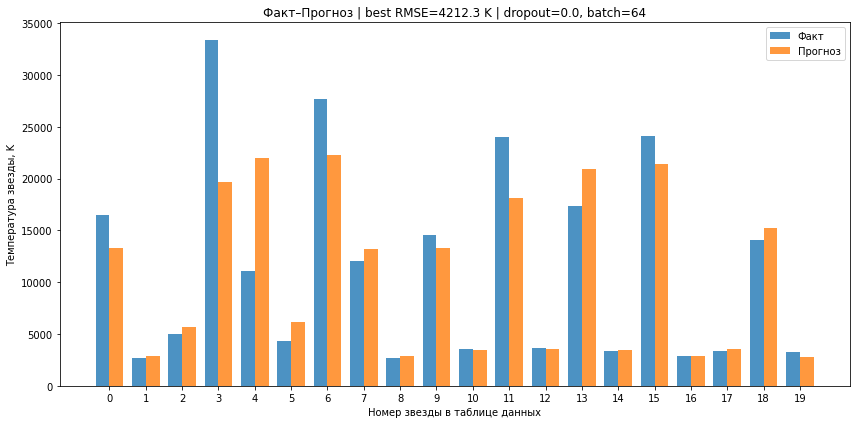

In [49]:
y_true = best["y_true"]
y_pred = best["y_pred"]

k = min(20, len(y_true)) # для 20 
idx = np.arange(k)

bar_width = 0.38
shift = bar_width / 2

plt.figure(figsize=(12, 6))
plt.bar(idx - shift, y_true[:k], width=bar_width, label="Факт", alpha=0.8)
plt.bar(idx + shift, y_pred[:k], width=bar_width, label="Прогноз", alpha=0.8)
plt.xlabel("Номер звезды в таблице данных")
plt.ylabel("Температура звезды, K")
plt.title(f"Факт–Прогноз | best RMSE={best['rmse']:.1f} K | dropout={best['dropout']}, batch={best['batch_size']}")
plt.xticks(idx)
plt.legend()
plt.tight_layout()
plt.show()

**Вывод по этапу 'Улучшение сети'**

* Перебор гиперпараметров. При фиксированной архитектуре baseline был выполнен перебор `dropout` от 0.0 до 0.3 и `batch_size` от 8 до 64. Для каждой комбинации модель обучалась и оценивалась по `RMSE` на тестовой выборке (в Кельвинах).

* Лучшая комбинация параметров: `dropout` = 0.0, `batch_size` = 64. Итоговая метрика: `RMSE` = 4212.3 K, что удовлетворяет требованию (≤ 4500 K). По таблице видно, что увеличение `dropout` в этом датасете чаще ухудшает `RMSE`, а более крупный `batch` = 64 оказался стабильнее и дал лучший результат.

* График `Факт–Прогноз`. По графику видно, что модель в целом попадает в правильный порядок величин и достаточно неплохо предсказывает температуру для большинства звёзд. При этом ошибки заметнее на высоких температурах (самые горячие звёзды часто недооцениваются или переоцениваются). 

## Выводы по проекту

**Этапы работы:**

Исходные данные и проведённая обработка данных:
* для исследовании использовались данные о звездах обсерватории «Небо на ладони», 
* в ходе предобработки данных были проверены типы данных, дубликаты и пропущенные значения в датасете: удалены неинформативные признаки (номер звезд), объединены категориальные  признаки, установлены разночтения
* в ходе исследовательского анализа был проведен статистический анализ данных, построена матрица корреляций Phik для выявления взаимосвязей.

Этап подготовки данных для моделирования: поделены данные на обучающую и тестовую выборки (75/25), внесены корректировки по данным: категоризация исходных данные, логорифмирование ассиметричных данных, масштабирование количественных данных.
 
Обучение и сравнение нейронных сетей.

**Результаты каждого типа модели**:
* Baseline-модель, простая нейросеть без подбора гиперпараметров:
 - Архитектура: MLP (Tanh, ReLU, Linear), обучение на стандартизированной целевой переменной с обратным преобразованием в Kельвины.
 - По графику Факт–Прогноз модель в целом улавливает порядок температур, но заметно ошибается на экстремально горячих звёздах.
 - Качество: RMSE = 4778 K, MAE ранее был около 2790 Kельвин.

* Улучшенная модель с той же архитектурой и перебором dropout и batch_size:
 - Архитектура не менялась, подбирались только гиперпараметры: dropout и batch_size.
 - Лучший результат достигнут при dropout=0.0, batch_size=64.
 - Качество: RMSE = 4212 Kельвин (выполнено требование ≤ 4500).


**Выводы сравнения двух моделей**

* Улучшенная модель показала лучшее качество: ошибка RMSE снизилась с 4778 до 4212 Kельвин, то есть примерно около 12% улучшения.
* Подбор параметров показал, что dropout в этой задаче не помогает, т.к.лучший результат при dropout = 0.0. На таком маленьком датасете и при выбранной архитектуре dropout, вероятно, сильнее уменьшает и подрезает модель, чем защищает от переобучения.
* А Вот увеличение batch_size до 64 дало наиболее стабильное обучение и лучший результат.

Baseline подходит как точка отсчёта, а улучшенная версия уже удовлетворяет целевому ограничению по ошибке RMSE. Дальнейший прирост качества потребует уже не перебора dropout и batch, а улучшения признаков категорий и увеличения датасета.